In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from itertools import product
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from xgboost import plot_importance


# Data exploration
Provided data contains time series with information about taxi rides from 1st March to 28th March 2022. For each data point we have accurate timestamp and location of start of the ride. Also end location and ride value are provided.

In [ ]:
data = pd.read_csv("taxi_rides.csv")
data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


In [ ]:
data.start_time.min(), data.start_time.max()

('2022-03-01 00:00:07.936317000', '2022-03-28 23:59:53.175658000')

We are extracting information about day, weekday, hour etc. for the purpose of further exploration and building the model.

In [ ]:
data["start_time"] = pd.to_datetime(data["start_time"])
data["year"] = data["start_time"].dt.year
data["month"] = data["start_time"].dt.month
data["day"] = data["start_time"].dt.day
data["weekday"] = data["start_time"].dt.weekday
data["hour"] = data["start_time"].dt.hour
data["minute"] = (data["start_time"].dt.minute // 10) * 10

In [ ]:
data["start_time"] = pd.to_datetime(data[["year", "month", "day", "hour", "minute"]])

In [ ]:
print(data.shape)
data.head()

(627210, 12)


,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,year,month,day,weekday,hour,minute
0,2022-03-06 15:00:00,59.407910,24.689836,59.513027,24.831630,3.51825,2022,3,6,6,15,0
1,2022-03-10 11:10:00,59.441650,24.762712,59.426450,24.783076,0.50750,2022,3,10,3,11,10
2,2022-03-06 14:20:00,59.435404,24.749795,59.431901,24.761588,0.19025,2022,3,6,6,14,20
3,2022-03-03 09:10:00,59.406920,24.659006,59.381093,24.641652,0.75600,2022,3,3,3,9,10
4,2022-03-06 00:10:00,59.434940,24.753641,59.489203,24.876170,2.27100,2022,3,6,6,0,10


We can see daily and weekly trend for the number of requested rides. E.g. every day there are fewer rides in the late night hours (3-4a.m.) and more in the afternoon (3-5p.m.). Also on the weekend there is a significant peak in the evening (9-10p.m.). 

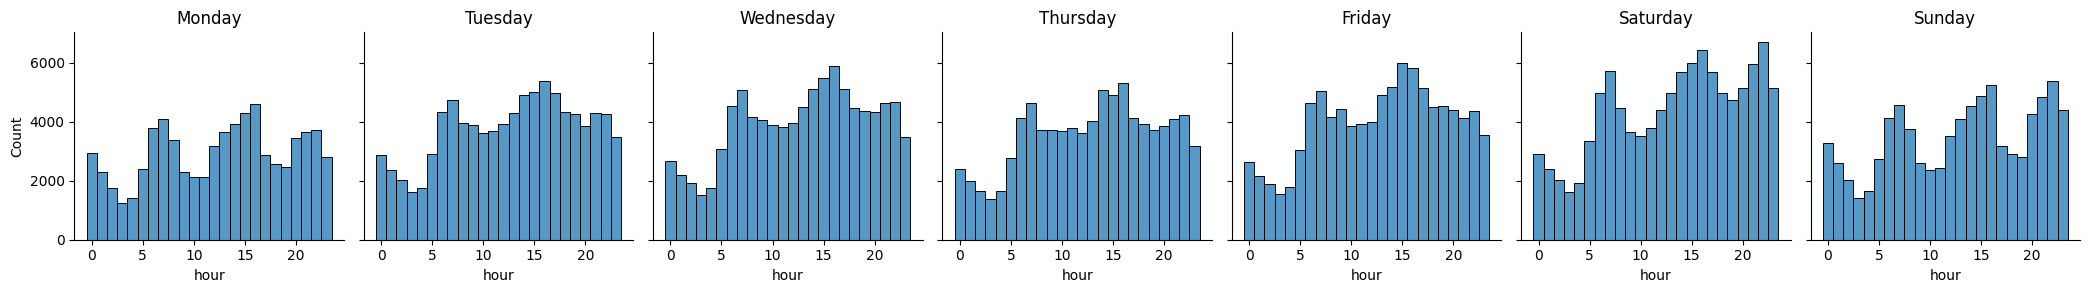

In [ ]:
g = sns.FacetGrid(data, col="weekday")
g.map_dataframe(sns.histplot, "hour", discrete=True)

axes = g.axes.flatten()
days = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')

for ix, ax in enumerate(axes):
  ax.set_title(days[ix])

We are getting read of data that may be corrupted, with unusually short or long rides. For that we need to calculate distance between start and end locations.

In [ ]:
def haversine_dist(lng1, lat1, lng2, lat2):
    lng1, lat1, lng2, lat2 = map(np.radians, [lng1, lat1, lng2, lat2])

    dlng = lng2 - lng1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    dist = 6367 * c
    return dist

In [ ]:
data["distance"] = haversine_dist(data["start_lng"], data["start_lat"], data["end_lng"], data["end_lat"])

In [ ]:
data = data[data["distance"] >= 0.1]
data = data[data["distance"] <= 100]
data.shape

(625379, 13)

We are plotting all starting points on the map of Tallin to see if the data makes sense.

In [ ]:
area_limits = (
    data["start_lng"].min().round(3),
    data["start_lng"].max().round(3),
    data["start_lat"].min().round(3),
    data["start_lat"].max().round(3),
    )
area_limits

(24.505, 24.974, 59.322, 59.567)

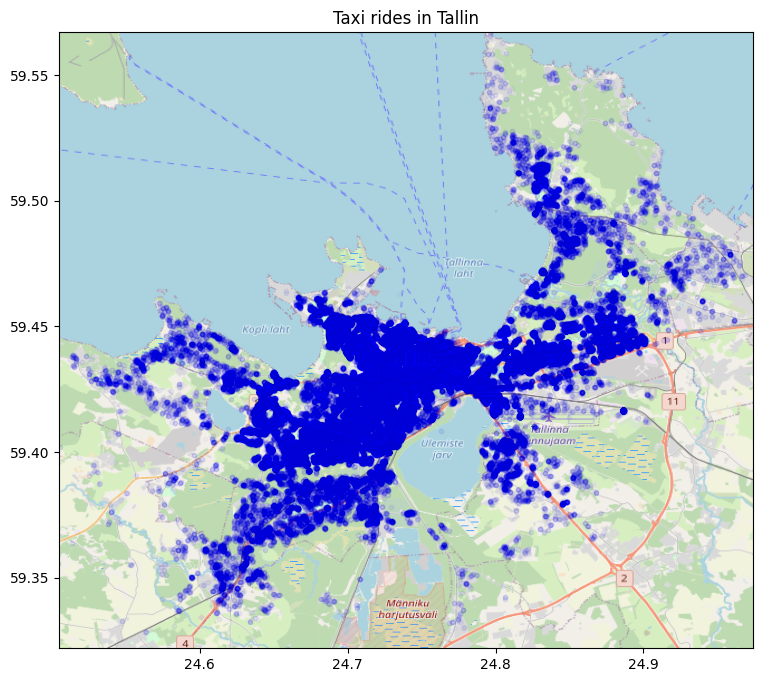

In [14]:
map_tallin = plt.imread("map_tallin.png")
fig, ax = plt.subplots(figsize=(13, 8))
ax.scatter(data["start_lng"], data["start_lat"], zorder=1, alpha=0.025, c="b", s=10)

ax.set_title("Taxi rides in Tallin")
ax.set_xlim(area_limits[0], area_limits[1])
ax.set_ylim(area_limits[2], area_limits[3])

ax.imshow(map_tallin, zorder=0, extent=area_limits, aspect=1.7);


## Model proposition
Having data about starting points in time, we want to create the model which will return demand of taxi rides in each region of Tallin, for defined weekday, hour and also using data about demand from previous hours.

First step will be to cluster starting points to regions. We will use KMeans algorithm for that.

In [15]:
start_points = data[["start_lat", "start_lng"]].values

k_means = KMeans(n_clusters=40)
k_means.fit(start_points)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=40)

In [16]:
data["cluster_id"] = k_means.labels_

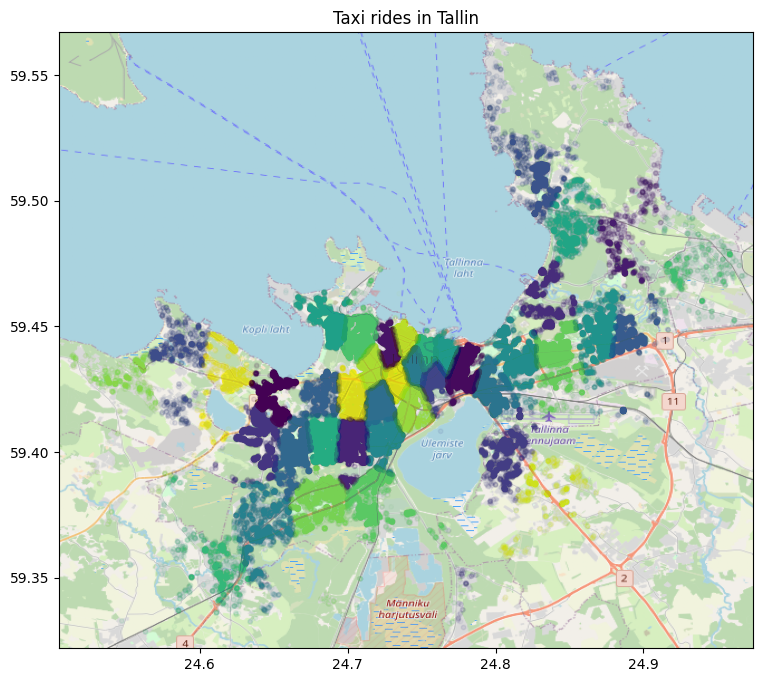

In [17]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.scatter(data["start_lng"], data["start_lat"], zorder=1, alpha=0.025, c=data["cluster_id"], s=10)

ax.set_title("Taxi rides in Tallin")
ax.set_xlim(area_limits[0], area_limits[1])
ax.set_ylim(area_limits[2], area_limits[3])

ax.imshow(map_tallin, zorder=0, extent=area_limits, aspect=1.7);

Response variable in our model will be number of rides for each region, weekday, hour and ten minutes period. Also we could predict sum of ride values or sum of distances starting from given region.

In [18]:
grouped_data = data.groupby(by=["cluster_id", "day", "weekday", "hour", "minute"]).aggregate({
    "ride_value": ["count", "sum"],
    "distance": "sum",
    })

In [19]:
grouped_data

ride_value              distance
                                        count        sum        sum
cluster_id day weekday hour minute                                 
0          1   1       0    0               2   1.403250   5.678056
                            10              1   0.969750   3.946192
                            20              1   0.655000   2.624622
                            30              4   6.338750  25.760843
                            40              4  12.746750  51.621068
...                                       ...        ...        ...
39         28  0       22   20              2   4.001250  16.300075
                            30              1   1.693250   6.885389
                            50              3   5.259192  21.394494
                       23   10              2   3.583750  14.563778
                            20              1   1.719811   7.026318

[130696 rows x 3 columns]

In [20]:
grouped_data.columns = ["number_of_rides", "ride_value_sum", "distance_sum"]
grouped_data = grouped_data.reset_index(level=["day", "weekday", "hour", "minute", "cluster_id"])
grouped_data

,cluster_id,day,weekday,hour,minute,number_of_rides,ride_value_sum,distance_sum
0,0,1,1,0,0,2,1.403250,5.678056
1,0,1,1,0,10,1,0.969750,3.946192
2,0,1,1,0,20,1,0.655000,2.624622
3,0,1,1,0,30,4,6.338750,25.760843
4,0,1,1,0,40,4,12.746750,51.621068
...,...,...,...,...,...,...,...,...
130691,39,28,0,22,20,2,4.001250,16.300075
130692,39,28,0,22,30,1,1.693250,6.885389
130693,39,28,0,22,50,3,5.259192,21.394494
130694,39,28,0,23,10,2,3.583750,14.563778


We need to make sure that for each combination of our time period (10 minutes) and cluster we will have a data point. Even if for given cluster and time period there is no data about rides it means that in column *number_of_rides* there should be a zero.

In [21]:
dictionary = {"cluster_id": range(40), 
              "day": range(1, 29), 
              "hour": range(24),
              "minute": range(0, 60, 10)
              }
all_groups = pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

In [22]:
all_groups.shape

(161280, 4)

In [23]:
grouped_data = pd.merge(grouped_data, all_groups, how="right", on=["cluster_id", "day", "hour", "minute"])
grouped_data["weekday"] = grouped_data["day"] % 7
grouped_data = grouped_data.fillna(0)
grouped_data["start_time"] = (
    pd.to_datetime("2022-02-28") +
    pd.to_timedelta(grouped_data["day"], unit="D") +
    pd.to_timedelta(grouped_data["hour"], unit="h") +
    pd.to_timedelta(grouped_data["minute"], unit="m")
)
grouped_data = grouped_data.set_index("start_time")
grouped_data.head(10)

,cluster_id,day,weekday,hour,minute,number_of_rides,ride_value_sum,distance_sum
start_time,,,,,,,,
2022-03-01 00:00:00,0,1,1,0,0,2.0,1.40325,5.678056
2022-03-01 00:10:00,0,1,1,0,10,1.0,0.96975,3.946192
2022-03-01 00:20:00,0,1,1,0,20,1.0,0.65500,2.624622
2022-03-01 00:30:00,0,1,1,0,30,4.0,6.33875,25.760843
2022-03-01 00:40:00,0,1,1,0,40,4.0,12.74675,51.621068
2022-03-01 00:50:00,0,1,1,0,50,1.0,1.47925,6.025775
2022-03-01 01:00:00,0,1,1,1,0,1.0,1.02400,4.150875
2022-03-01 01:10:00,0,1,1,1,10,2.0,2.09050,8.492128
2022-03-01 01:20:00,0,1,1,1,20,4.0,5.54200,22.513577


Model will be trained on the first three weeks of data, last week will be used as a test set.

In [24]:
train_data = grouped_data.copy()[grouped_data.day <= 21]
test_data = grouped_data.copy()[grouped_data.day > 21]

Our model will be supervised machine learning model but we will add time series component by preparing additional columns with information about past number of rides in period from 2 hours up to 1 hour before given point in time. It means that, in the given moment, we could predict demand up to one hour in the future. 
We will use one and two hours lag as well as mean in this period.

In [25]:
train_data["number_of_rides_1_hour_lag"] = train_data.groupby(by="cluster_id")["number_of_rides"].shift(6)
train_data["number_of_rides_2_hour_lag"] = train_data.groupby(by="cluster_id")["number_of_rides"].shift(12)
train_data["number_of_rides_1_hour_mean"] = train_data.groupby(by="cluster_id")["number_of_rides"].rolling(window = 6, closed="left").mean().shift(6).reset_index(level="cluster_id", drop=True)

test_data["number_of_rides_1_hour_lag"] = test_data.groupby(by="cluster_id")["number_of_rides"].shift(6)
test_data["number_of_rides_2_hour_lag"] = test_data.groupby(by="cluster_id")["number_of_rides"].shift(12)
test_data["number_of_rides_1_hour_mean"] = test_data.groupby(by="cluster_id")["number_of_rides"].rolling(window = 6, closed="left").mean().shift(6).reset_index(level="cluster_id", drop=True)

In [26]:
X_cols = ["weekday", "hour", "minute", "cluster_id", "number_of_rides_1_hour_lag", "number_of_rides_2_hour_lag", "number_of_rides_1_hour_mean"]
X_train = train_data[X_cols]
y_train = train_data["number_of_rides"]
X_test = test_data[X_cols]
y_test = test_data["number_of_rides"]

We will train XGBoost model. It will be our baseline model. When we decide to improve the solution using more data and/or more complicated models, we can compare results to XGBoost.

In [27]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

The most important features indicating taxi demand are *cluster_id* and *hour*. Also features calculated using past data seem to be useful: *number_of_rides_1_hour_lag*, *number_of_rides_2_hour_lag*, *number_of_rides_1_hour_mean*.

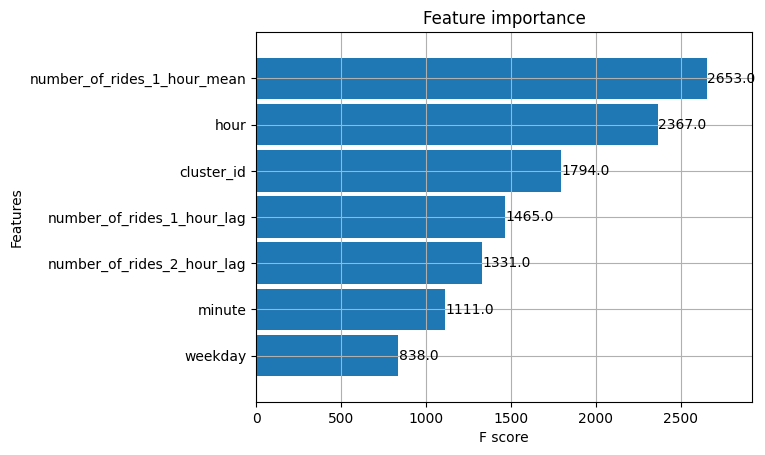

In [28]:
plot_importance(reg, height=0.9);

In [29]:
test_data["predicted_number_of_rides"] = reg.predict(X_test)
data_with_test_predictions = pd.concat([train_data, test_data], sort=False)

R2 score for our baseline model is 0.78.

In [30]:
r2_score(test_data["number_of_rides"], test_data["predicted_number_of_rides"])

0.7669800623333377

Lookinh at the plot of predicted number of rides vs actual number of rides we can say that number of rides seem to be underestimated by our model but general trend is preserved.

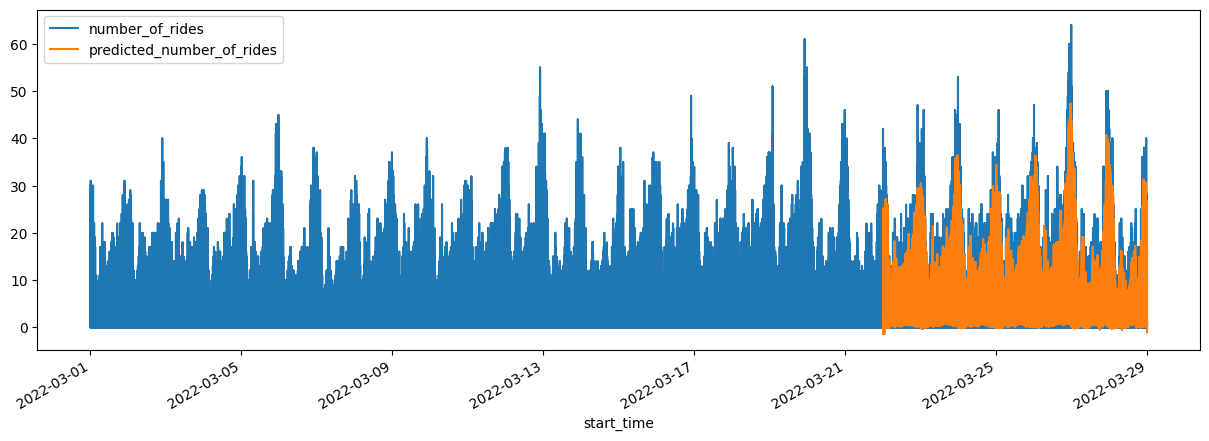

In [31]:
data_with_test_predictions[["number_of_rides","predicted_number_of_rides"]].plot(figsize=(15, 5));

We can look into more details by plotting predictions for one cluster only. Let's check clusters with the highest numbers of rides. These clusters are the most important in our solution because towards these clusters we will redirect drivers.

In [32]:
data_with_test_predictions.groupby(by=["cluster_id"]).number_of_rides.sum().sort_values(ascending=False).head()

cluster_id
16    57440.0
25    53862.0
1     39451.0
21    30839.0
8     29555.0
Name: number_of_rides, dtype: float64

Model works good for clusters with high number of rides.

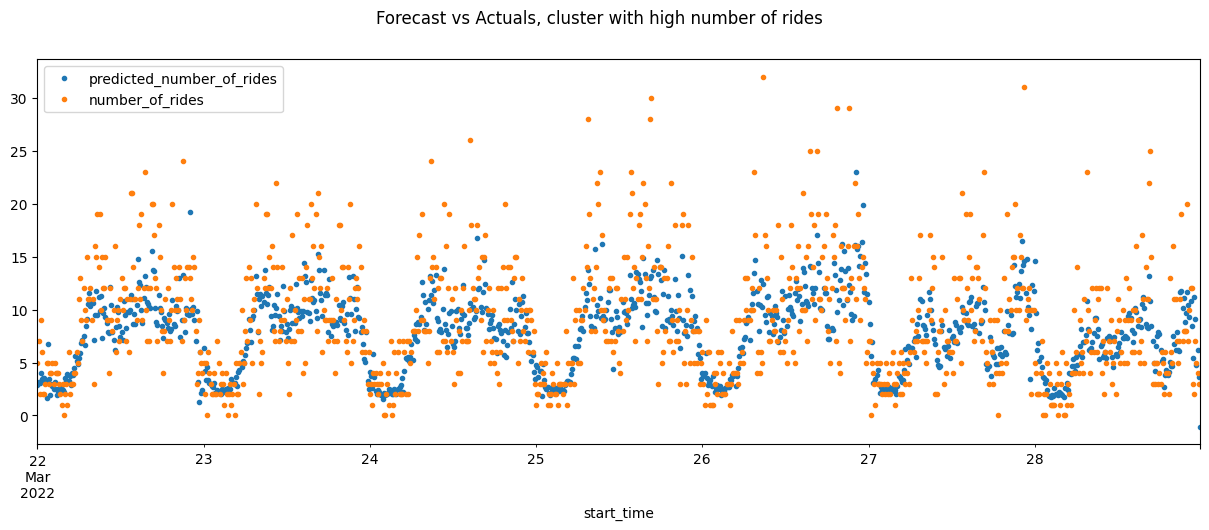

In [33]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
data_with_test_predictions.loc[(data_with_test_predictions["day"] > 21) & (data_with_test_predictions["cluster_id"] == 21), ["predicted_number_of_rides","number_of_rides"]].plot(ax=ax, style=['.','.'])
plt.suptitle("Forecast vs Actuals, cluster with high number of rides");

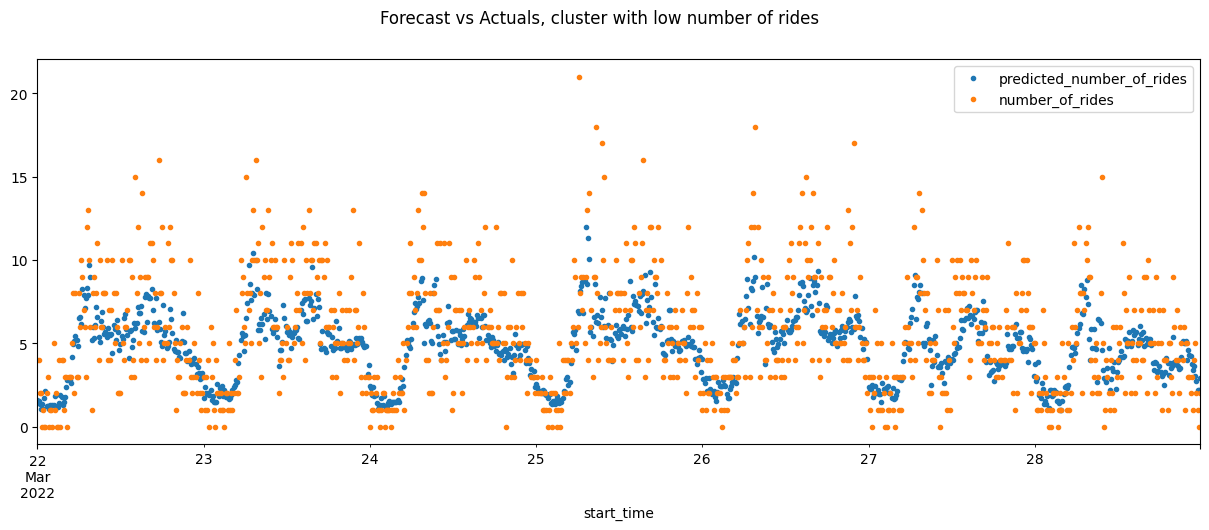

In [34]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
data_with_test_predictions.loc[(data_with_test_predictions["day"] > 21) & (data_with_test_predictions["cluster_id"] == 4), ["predicted_number_of_rides","number_of_rides"]].plot(ax=ax, style=['.','.'])
plt.suptitle("Forecast vs Actuals, cluster with low number of rides");

# Model architecture
Assumptions:
* Model requires clusters precomputed based on historical data with starting points of taxi rides. 
* Each data point signifies one successful taxi ride.
* Each data point needs to be assigned to one of cluster ids.
* Each data point needs to have its start time timestamp with accuracy of at least 10 minutes.
* Data points from 2 hours to 1 hour ago are available for prediction.

Preprocessing:
* All data points are grouped and counted by clusters and time periods, in our case 10-minutes periods.
* We don't want to have gaps in the data so if there are some time periods - clusters combinations for which there were no rides registered, those combinations need to be add to the data set with zero values.
* Column with mean of number of rides in the period from 2 hours ago to 1 hour ago is added to the data set.
* Columns with number of rides from 1 hour ago and 2 hours ago is added to the data set.

Training:
* Data set prepared as described above is ready for the supervised machine learning training.
* Response variable: *number_of_rides*.
* Explanatory variables: *weekday*, *hour*, *minute*, *cluster_id*, *number_of_rides_1_hour_lag*, *number_of_rides_2_hour_lag*, *number_of_rides_1_hour_mean*.
* Explanatory variables that might be useful but were not available in this analysis: information about weather, traffic, people density.
* XGBoost regression model is used for training.

Prediction:
* Having data about demand from the last two hours, we can make predictions up to one hour in the future.

# Model deployment
1. Collect the data.
2. Compute clusters locally using KMeans algorithm.
3. Train XGBoost model locally. Save it.
4. Send the trained model to cloud storage, e.g. on GCP.
5. Test the model on new data.
6. Train new model every month. Use versioning to store old models on the cloud, not to lose them in case of any problems with new models.




# Use of the model
Having model deployed on some cloud storage, we can use it in taxi app. Make predictions for given time period for each region (cluster) up to one hour in the future. Calculate the difference between demand in each region and number of drivers currently available there. Redirect the drivers from the regions where there is a lower demand than number of drivers to the regions where there is a higher demand. Starting with the drivers who are the closest to the regions which have the highest demand. 

Taxi app would send notifications to the drivers that would be selected by algorithm, suggesting them to move to the other region. Driver can accept or decline suggestion.

## Solution validation
1. Collect the data about gap between demand and number of drivers in all 
regions.
2. Compare one week of data where redirecting solution was not used to the data from the week where redirecting solution was applied. Check if the absolute value of gap between demand and number of drivers in all regions decreased.
3. Compare other metrics, e.g. time of waiting for the ride, distance drivers need to cover to get to the starting points. New solution, if successful, should also improve these metrics.
